In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpjtaed8lq/pubring.gpg' created
gpg: /tmp/tmpjtaed8lq/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
import os
os.chdir("drive/ML_Notebooks")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam, RMSprop, Nadam, SGD, Adagrad, Adadelta
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, MaxPool2D
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
train_file_x = 'train_x_processed_2c.csv'
train_file_y = 'train_y.csv'
test_file = 'test_x_processed_2c.csv'
output_file = 'submission.csv'

In [6]:
print('Loading data . . .')

train_x = np.loadtxt(train_file_x, delimiter=",") # load from text
train_y = np.loadtxt(train_file_y, delimiter=",")
x_test = np.loadtxt(test_file, delimiter=",")

print('Data loaded . . .')

Loading data . . .
Data loaded . . .


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.2)

X_train = X_train.reshape(X_train.shape[0], 64, 64, 1)
X_test = X_test.reshape(X_test.shape[0], 64, 64, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

def preProcessing(dataset):
  for j in range(len(dataset)):
    temp = dataset[j]
    temp[temp < 251] = 0
    temp[temp >= 251] = 255
    dataset[j] = temp
    
  return dataset

# print('Processing data. . .')

# X_train = preProcessing(X_train)
# X_test = preProcessing(X_test)

print('Normalizing data. . .')
X_train/=255
X_test/=255

print('Data normalized. . .')



Normalizing data. . .
Data normalized. . .


In [0]:
number_of_classes = 10

Y_train = np_utils.to_categorical(Y_train, number_of_classes)
Y_test = np_utils.to_categorical(Y_test, number_of_classes)

In [9]:
print('Initializing model. . . ')

#Best Model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(64, 64, 1)))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
          
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
          
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
 
model.add(Dense(10, activation='softmax'))


#Augmentation

datagen = ImageDataGenerator(rotation_range=8, 
                             width_shift_range=0.08, 
                             shear_range=0.3,
                             height_shift_range=0.08, 
                             zoom_range=0.08)

Initializing model. . . 


In [0]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), metrics=["accuracy"])

In [0]:
annealer = ReduceLROnPlateau(monitor='val_acc', 
                                patience=3, 
                                verbose=1, 
                                factor=0.5, 
                                min_lr=0.00001)

In [14]:
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
                           steps_per_epoch=1000,
                           epochs=30, #Increase this when not on Kaggle kernel
                           verbose=1,  #1 for ETA, 0 for silent
                           validation_data=(X_test[:4000,:], Y_test[:4000,:]), #For speed
                           callbacks=[annealer])

Epoch 1/30
1000/1000 [==============================] - 43s 43ms/step - loss: 2.3016 - acc: 0.1117 - val_loss: 2.3016 - val_acc: 0.1090
Epoch 2/30
 459/1000 [============>.................] - ETA: 22s - loss: 2.3018 - acc: 0.10811000/1000 [==============================] - 43s 43ms/step - loss: 2.3021 - acc: 0.1080 - val_loss: 2.3017 - val_acc: 0.1090
Epoch 3/30
 705/1000 [====================>.........] - ETA: 12s - loss: 2.3015 - acc: 0.11081000/1000 [==============================] - 43s 43ms/step - loss: 2.3013 - acc: 0.1113 - val_loss: 2.3016 - val_acc: 0.1090
Epoch 4/30
 799/1000 [======================>.......] - ETA: 8s - loss: 2.3019 - acc: 0.10931000/1000 [==============================] - 43s 43ms/step - loss: 2.3019 - acc: 0.1081 - val_loss: 2.3016 - val_acc: 0.1090
Epoch 5/30
 833/1000 [=======================>......] - ETA: 7s - loss: 2.3017 - acc: 0.11101000/1000 [==============================] - 43s 43ms/step - loss: 2.3017 - acc: 0.1111 - val_loss: 2.3017 - val_acc: 0

KeyboardInterrupt: ignored

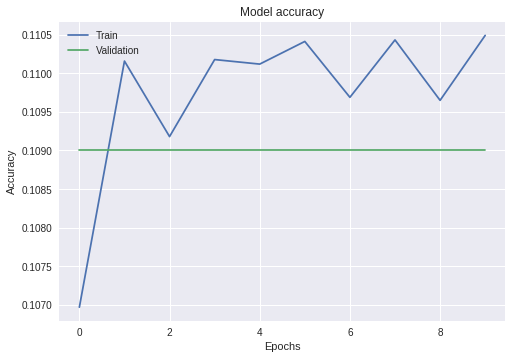

In [15]:
#  "Accuracy"
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

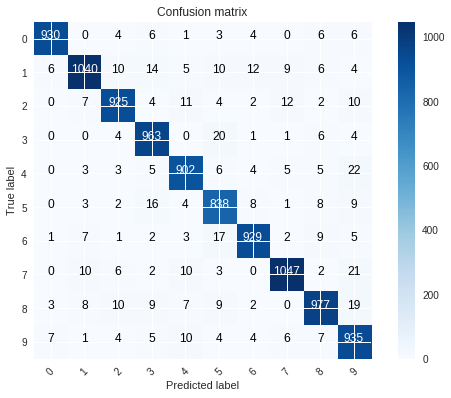

In [22]:
import itertools

# Look at confusion matrix (Raw Data)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))


In [14]:
# Test data

x_test = x_test.reshape(x_test.shape[0], 64, 64, 1)
# x_test = preProcessing(x_test)

print('Normalizing data. . .')
x_test/=255


predictions = model.predict_classes(x_test, verbose=0)

Normalizing data. . .


In [59]:
#Raw Data
final_loss, final_acc = model.evaluate(X_test, Y_test, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.2149, final accuracy: 0.9580


In [0]:
submissions=pd.DataFrame({"Id": list(range(0,len(predictions))),
                         "Label": predictions})
submissions.to_csv("submission.csv", index=False, header=True)